On recommence en mettant la boucle et en ajoutant la baseline : 

##
<center><span style="color: seagreen; font-size: 50px; font-style: bold">Pipeline d'analyse de spectres de spectroscopie Raman avec méthode SERS pour titration du Cuivre</span></center>


<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <title>Pipeline d'analyse de spectre de spectroscopie Raman avec méthode SERS pour titration du Cuivre</title>
    <style>
        body {
            font-family: Arial, sans-serif;
        }
        h1 {
            color: skyblue;
            font-size: 24px;
        }
        p, li {
            font-size: 16px;
        }
        .green-text{
            color: DarkSeaGreen;
        }
    </style>
</head>
<body>
    <h1>Analyse spectroscopique</h1>
    <p>Ce code permet d'analyser les données issues de spectroscope Raman. Les données doivent être données dans des fichiers standarisé ".txt". Le code fonctionne comme suit: </p>
    <ol>
        <li><strong class="green-text">Récupération des spectres :</strong> Collecte de tous les spectres issus d'une même expérience.</li>
        <li><strong class="green-text"> Pré-traitement:</strong> Soustraction d'une base-line pour uniformisé les spectres.</li>
        <li><strong class="green-text"> Téléchargement des métadonnés de l'expérience:</strong> Un tableur récapitulant l'intégralité des manipulations lors de l'expérience est chargé pour compléter les données nécessaires à la titration.</li>
        <li><strong class="green-text"> Hauteur de pics:</strong> Lecture de la valeur des pics définis, et calcul de leur rapport pour chaque mesure.</li>
        <li><strong class="green-text"Tracè des courbes de titrations :</strong> Application de méthodes statistiques aux trajectoires conservées. Les données peuvent être séparées en deux populations pour un traitement spécifique si nécessaire.</li>
    </ol>
</body>
</html>


<span style="color: skyblue; font-size: 20px; font-style: bold">Chargement des librairies.</span>

In [157]:
import os
import re
import itertools
import numpy as np
import pandas as pd
from pybaselines import Baseline
from plotnine import ggplot, aes, geom_point, geom_line, theme_bw, labs, scale_color_brewer, theme, scale_x_continuous, ylim
import matplotlib.pyplot as plt

<span style="color: skyblue; font-size: 20px; font-style: bold"> Paramètresde l'étude </span>

In [136]:
EXPERIMENT_NAME = "AS003"
WAVELENGTH = "532nm"
EXPERIMENT_FOLDER = EXPERIMENT_NAME + "_" +WAVELENGTH
data_dir = os.path.join('/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/', EXPERIMENT_FOLDER)

<span style="color: skyblue; font-size: 20px; font-style: bold"> Téléchargement des méta-donnés de l'expérience </span>

In [137]:
# Lecture du fichier Excel de métadonnées :
metadata_path = "/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/"
metadata_df = pd.read_excel(metadata_path + EXPERIMENT_NAME + "_metadata.xlsx", skiprows=1)
metadata_df.head()

,Spectrum name,Sample description,nb average,laser.pwr,laser.WL (nm),acq.time (s),pH,Nb eq,V(EGTA) (µL),V(BRB) (µL),n(EGTA) (mol),C(Cu) (nM),C(Ag) (mM)
0,AS003_01,Cuvette BRB,1,30,532,3,NaN,0.0,0.0,500.0,0.000000e+00,0.0,0.0
1,AS003_02,Cuvette 16 - 0eq EGTA,1,30,532,3,NaN,0.0,0.0,500.0,0.000000e+00,491.0,1.0
2,AS003_03,Cuvette 17 - 2eq EGTA,1,30,532,3,NaN,2.0,446.0,54.0,9.812000e-10,491.0,1.0
3,AS003_04,Cuvette BRB,1,30,532,3,NaN,0.0,0.0,500.0,0.000000e+00,0.0,0.0
4,AS003_05,Cuvette 1 - Oeq EGTA,1,30,532,3,7.82,0.0,0.0,500.0,0.000000e+00,491.0,1.0


<span style="color: skyblue; font-size: 20px; font-style: bold"> Liste des fichiers de la manip </span>

In [138]:
spectrocopy_files = [f for f in os.listdir(data_dir)
                    if f.endswith('.txt')]

# trie dans l'ordre croissant en extrayant la partie numérique
spectrocopy_files = sorted(
    spectrocopy_files,
    key=lambda x: int(re.search(r'_(\d+)\.txt$', x).group(1)) 
)

spectrocopy_files

['AS003_01.txt',
 'AS003_02.txt',
 'AS003_03.txt',
 'AS003_04.txt',
 'AS003_05.txt',
 'AS003_06.txt',
 'AS003_07.txt',
 'AS003_08.txt',
 'AS003_09.txt',
 'AS003_10.txt',
 'AS003_11.txt',
 'AS003_12.txt',
 'AS003_13.txt',
 'AS003_14.txt',
 'AS003_15.txt',
 'AS003_16.txt',
 'AS003_17.txt',
 'AS003_18.txt',
 'AS003_19.txt',
 'AS003_20.txt',
 'AS003_21.txt',
 'AS003_22.txt',
 'AS003_219.txt',
 'AS003_220.txt']

<span style="color: skyblue; font-size: 20px; font-style: bold"> Démonstration de la soustraction de la baseLine sur spectre </span>

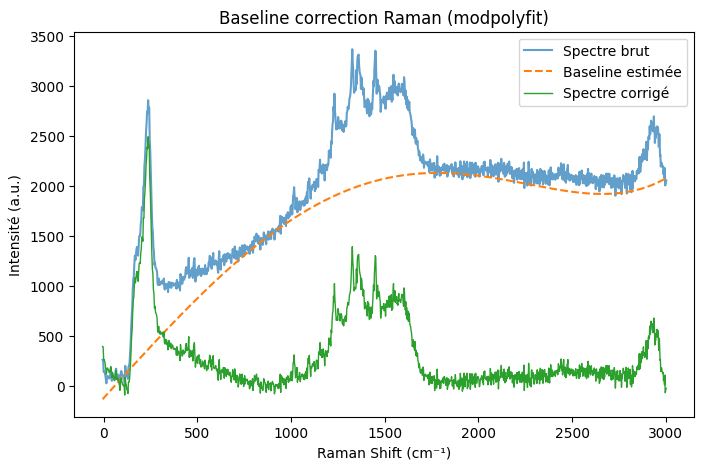

In [139]:
# Exemple : on prend un seul spectre
file_path = os.path.join(data_dir, spectrocopy_files[1])
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

header_idx = next(i for i, line in enumerate(lines)
                if line.strip().startswith('Pixel;'))

# lire le fichier
df = pd.read_csv(file_path,
                    skiprows=header_idx,
                    sep=";",
                    decimal=",",
                    encoding="utf-8",
                    skipinitialspace=True,
                    na_values=["", " ", "   ", "\t"],
                    keep_default_na=True)

# supprimer la dernière colonne si vide
if df.columns[-1].startswith("Unnamed"):
    df = df.iloc[:, :-1]

# convertir en numérique
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# garder seulement les colonnes utiles
temp = df[["Wavenumber", "Wavelength", "Raman Shift", "Dark Subtracted #1"]].copy()
temp = temp.dropna()

# baseline correction avec modpolyfit
x = temp["Raman Shift"].values
y = temp["Dark Subtracted #1"].values

# Initialiser le modèle
baseline_fitter = Baseline(x)

# Méthode polynomial modpolyfit (comme en R)
baseline, params = baseline_fitter.modpoly(y, poly_order=5)

# Corriger le spectre
y_corrected = y - baseline

# Affichage
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Spectre brut", alpha=0.7)
plt.plot(x, baseline, label="Baseline estimée", linestyle="--")
plt.plot(x, y_corrected, label="Spectre corrigé", linewidth=1)
plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Intensité (a.u.)")
plt.legend()
plt.title("Baseline correction Raman (modpolyfit)")
plt.show()

<span style="color: skyblue; font-size: 20px; font-style: bold"> Téléchargement de tous les spectres, application de la baseline, et concaténation de tous les spectres en une seule variable "spectra_df" </span>

In [140]:
all_data = []

for fname in spectrocopy_files:   # ta liste triée
    file_path = os.path.join(data_dir, fname)

    # repérer la ligne de l'en-tête
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    header_idx = next(i for i, line in enumerate(lines)
                      if line.strip().startswith('Pixel;'))

    # lire le fichier
    df = pd.read_csv(file_path,
                     skiprows=header_idx,
                     sep=";",
                     decimal=",",
                     encoding="utf-8",
                     skipinitialspace=True,
                     na_values=["", " ", "   ", "\t"],
                     keep_default_na=True)

    # supprimer la dernière colonne si vide
    if df.columns[-1].startswith("Unnamed"):
        df = df.iloc[:, :-1]

    # convertir en numérique
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # garder seulement les colonnes utiles
    temp = df[["Wavenumber", "Wavelength", "Raman Shift", "Dark Subtracted #1"]].copy()
    temp = temp.dropna()

    # baseline correction avec modpolyfit
    x = temp["Raman Shift"].values
    y = temp["Dark Subtracted #1"].values
    baseline_fitter = Baseline(x)
    baseline, _ = baseline_fitter.modpoly(y, poly_order=5)

    # ajouter la colonne corrigée
    temp["Intensity_corrected"] = y - baseline
    temp = temp.dropna(subset=["Intensity_corrected"])

    # ajouter une colonne "fichier"
    temp["file"] = fname

    # stocker dans la liste
    all_data.append(temp)

# fusionner tous les fichiers
spectra_df = pd.concat(all_data, ignore_index=True)

spectra_df.head()
# print(spectra_df["file"].unique())

,Wavenumber,Wavelength,Raman Shift,Dark Subtracted #1,Intensity_corrected,file
0,18799.81,531.92,-4.95,328.6667,519.973926,AS003_01.txt
1,18796.91,532.00,-2.05,331.0000,516.631852,AS003_01.txt
2,18794.01,532.08,0.86,156.3333,336.332828,AS003_01.txt
3,18791.11,532.17,3.76,102.3333,276.781821,AS003_01.txt
4,18788.21,532.25,6.65,100.6667,269.644449,AS003_01.txt


<span style="color: skyblue; font-size: 20px; font-style: bold"> Fusion entre datas et metadatas  </span>

In [141]:
#  Création d'une clé de jointure dans spectra_df 
# (on enlève ".txt" pour matcher le nom type"AS00X_Y" dans l'Excel
spectra_df["Spectrum name"] = spectra_df["file"].str.replace(".txt", "", regex=False)

# Fusion des deux tables : 
combined_df = pd.merge(
    spectra_df,
    metadata_df,
    on="Spectrum name",
    how="left"   # garde toutes les lignes de spectra_df
)

# Print du résultat
combined_df.head()

# Sauvegarde
# combined_df.to_excel("Spectres_fusionnés.xlsx", index=False)

,Wavenumber,Wavelength,Raman Shift,Dark Subtracted #1,Intensity_corrected,file,Spectrum name,Sample description,nb average,laser.pwr,laser.WL (nm),acq.time (s),pH,Nb eq,V(EGTA) (µL),V(BRB) (µL),n(EGTA) (mol),C(Cu) (nM),C(Ag) (mM)
0,18799.81,531.92,-4.95,328.6667,519.973926,AS003_01.txt,AS003_01,Cuvette BRB,1,30,532,3,NaN,0.0,0.0,500.0,0.0,0.0,0.0
1,18796.91,532.00,-2.05,331.0000,516.631852,AS003_01.txt,AS003_01,Cuvette BRB,1,30,532,3,NaN,0.0,0.0,500.0,0.0,0.0,0.0
2,18794.01,532.08,0.86,156.3333,336.332828,AS003_01.txt,AS003_01,Cuvette BRB,1,30,532,3,NaN,0.0,0.0,500.0,0.0,0.0,0.0
3,18791.11,532.17,3.76,102.3333,276.781821,AS003_01.txt,AS003_01,Cuvette BRB,1,30,532,3,NaN,0.0,0.0,500.0,0.0,0.0,0.0
4,18788.21,532.25,6.65,100.6667,269.644449,AS003_01.txt,AS003_01,Cuvette BRB,1,30,532,3,NaN,0.0,0.0,500.0,0.0,0.0,0.0


<span style="color: skyblue; font-size: 20px; font-style: bold"> Spectre </span>

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/mizani/palettes.py:557: UserWarning:

Warning message:Brewer palette Paired has a maximum of 12 colors Returning the palette you asked for with that many colors

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/mizani/palettes.py:557: UserWarning:

Warning message:Brewer palette Paired has a maximum of 12 colors Returning the palette you asked for with that many colors



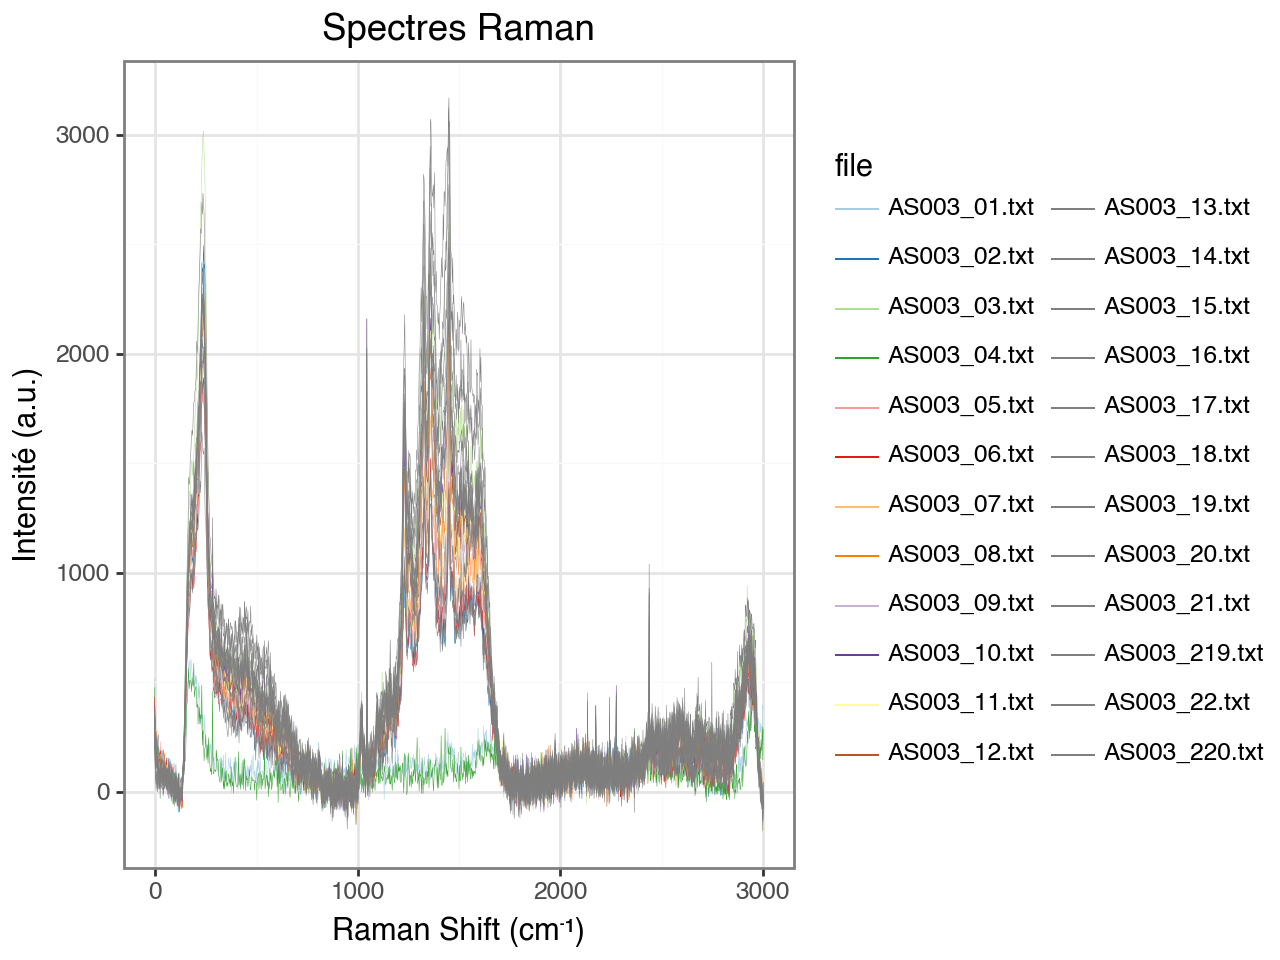

In [142]:
p = (
    ggplot(combined_df, aes(x="Raman Shift", y="Intensity_corrected", color="file"))
    + geom_line(size=0.1)
    + theme_bw()
    + labs(
        title="Spectres Raman",
        x="Raman Shift (cm⁻¹)",
        y="Intensité (a.u.)"
    )
    + scale_color_brewer(type='qual', palette='Paired')  # ou 'Dark2', 'Paired', etc.
)

p


<span style="color: skyblue; font-size: 20px; font-style: bold"> Spectre interactifs </span>

In [143]:
import plotly.express as px

fig = px.line(combined_df, 
              x="Raman Shift", 
              y="Intensity_corrected", 
              color="file",
              title="Spectres Raman interactifs")

fig.update_layout(
    xaxis_title="Raman Shift (cm⁻¹)",
    yaxis_title="Intensité (a.u.)",
    width=1900,   # largeur en pixels
    height=1000   # hauteur en pixels
)

fig.show()

<span style="color: skyblue; font-size: 20px; font-style: bold"> Définitions des pics d'étude </span>

In [ ]:
# Liste des pics d’intérêt (en cm⁻¹)
peaks = [1231, 1327, 1358, 1450]

<span style="color: skyblue; font-size: 20px; font-style: bold"> Récupération des valeurs de pics </span>

In [ ]:
# Largeur de la fenêtre de recherche autour de chaque pic
tolerance = 5  # ±5 cm⁻¹

results = []

for fname, group in combined_df.groupby("file"):
    spectrum = group.sort_values("Raman Shift")

    record = {"file": fname}

    for target in peaks:
        # on sélectionne la fenêtre autour du Raman Shift cible
        window = spectrum[
            (spectrum["Raman Shift"] >= target - tolerance) &
            (spectrum["Raman Shift"] <= target + tolerance)
        ]

        if not window.empty:
            # on prend le maximum corrigé dans cette zone
            record[f"I_{target}"] = window["Intensity_corrected"].max()
        else:
            record[f"I_{target}"] = np.nan

    results.append(record)

peak_intensities = pd.DataFrame(results)
peak_intensities.head()

,file,I_1231,I_1327,I_1358,I_1450
0,AS003_01.txt,177.087910,161.320492,152.902956,271.904793
1,AS003_02.txt,1022.560734,1392.702357,1316.060882,1303.917675
2,AS003_03.txt,1702.964159,2265.348436,2404.199586,2592.660290
3,AS003_04.txt,175.567801,67.486764,148.630406,204.069387
4,AS003_05.txt,1055.406987,1490.913310,1516.887500,1365.287600


In [160]:
for (target_a, target_b) in itertools.combinations(peaks, 2):
    peak_intensities[f"ratio_I_{target_a}_I_{target_b}"] = (
        peak_intensities[f"I_{target_a}"] / peak_intensities[f"I_{target_b}"]
    )
peak_intensities.head(10)

,file,I_1231,I_1327,I_1358,I_1450,ratio_I_1231_I_1327,ratio_I_1231_I_1358,ratio_I_1231_I_1450,ratio_I_1327_I_1358,ratio_I_1327_I_1450,ratio_I_1358_I_1450,Spectrum name
0,AS003_01.txt,177.087910,161.320492,152.902956,271.904793,1.097740,1.158172,0.651286,1.055051,0.593298,0.562340,AS003_01
1,AS003_02.txt,1022.560734,1392.702357,1316.060882,1303.917675,0.734228,0.776986,0.784222,1.058236,1.068091,1.009313,AS003_02
2,AS003_03.txt,1702.964159,2265.348436,2404.199586,2592.660290,0.751745,0.708329,0.656840,0.942246,0.873754,0.927310,AS003_03
3,AS003_04.txt,175.567801,67.486764,148.630406,204.069387,2.601515,1.181237,0.860334,0.454058,0.330705,0.728333,AS003_04
4,AS003_05.txt,1055.406987,1490.913310,1516.887500,1365.287600,0.707893,0.695771,0.773029,0.982877,1.092014,1.111039,AS003_05
5,AS003_06.txt,1013.235417,1339.608792,1522.611828,1414.868932,0.756367,0.665459,0.716134,0.879810,0.946808,1.076150,AS003_06
6,AS003_07.txt,1206.079463,1543.256180,1717.931360,1686.339571,0.781516,0.702053,0.715206,0.898322,0.915151,1.018734,AS003_07
7,AS003_08.txt,1435.979862,1780.111951,1932.488077,1960.209185,0.806680,0.743073,0.732565,0.921150,0.908123,0.985858,AS003_08
8,AS003_09.txt,1372.209037,1784.660640,1936.105021,1929.946725,0.768891,0.708747,0.711009,0.921779,0.924720,1.003191,AS003_09
9,AS003_10.txt,1589.764957,1946.587702,2162.139706,2156.465692,0.816693,0.735274,0.737209,0.900306,0.902675,1.002631,AS003_10


In [161]:
# Fusion des intensités avec les métadonnées
peak_intensities["Spectrum name"] = peak_intensities["file"].str.replace(".txt", "", regex=False)
merged = peak_intensities.merge(metadata_df, on="Spectrum name", how="left")
merged.head(10)

,file,I_1231,I_1327,I_1358,I_1450,ratio_I_1231_I_1327,ratio_I_1231_I_1358,ratio_I_1231_I_1450,ratio_I_1327_I_1358,ratio_I_1327_I_1450,...,laser.pwr,laser.WL (nm),acq.time (s),pH,Nb eq,V(EGTA) (µL),V(BRB) (µL),n(EGTA) (mol),C(Cu) (nM),C(Ag) (mM)
0,AS003_01.txt,177.087910,161.320492,152.902956,271.904793,1.097740,1.158172,0.651286,1.055051,0.593298,...,30,532,3,NaN,0.0,0.0,500.0,0.000000e+00,0.0,0.0
1,AS003_02.txt,1022.560734,1392.702357,1316.060882,1303.917675,0.734228,0.776986,0.784222,1.058236,1.068091,...,30,532,3,NaN,0.0,0.0,500.0,0.000000e+00,491.0,1.0
2,AS003_03.txt,1702.964159,2265.348436,2404.199586,2592.660290,0.751745,0.708329,0.656840,0.942246,0.873754,...,30,532,3,NaN,2.0,446.0,54.0,9.812000e-10,491.0,1.0
3,AS003_04.txt,175.567801,67.486764,148.630406,204.069387,2.601515,1.181237,0.860334,0.454058,0.330705,...,30,532,3,NaN,0.0,0.0,500.0,0.000000e+00,0.0,0.0
4,AS003_05.txt,1055.406987,1490.913310,1516.887500,1365.287600,0.707893,0.695771,0.773029,0.982877,1.092014,...,30,532,3,7.82,0.0,0.0,500.0,0.000000e+00,491.0,1.0
5,AS003_06.txt,1013.235417,1339.608792,1522.611828,1414.868932,0.756367,0.665459,0.716134,0.879810,0.946808,...,30,532,3,NaN,0.2,45.0,455.0,9.900000e-11,491.0,1.0
6,AS003_07.txt,1206.079463,1543.256180,1717.931360,1686.339571,0.781516,0.702053,0.715206,0.898322,0.915151,...,30,532,3,NaN,0.4,89.0,411.0,1.958000e-10,491.0,1.0
7,AS003_08.txt,1435.979862,1780.111951,1932.488077,1960.209185,0.806680,0.743073,0.732565,0.921150,0.908123,...,30,532,3,NaN,0.6,134.0,366.0,2.948000e-10,491.0,1.0
8,AS003_09.txt,1372.209037,1784.660640,1936.105021,1929.946725,0.768891,0.708747,0.711009,0.921779,0.924720,...,30,532,3,NaN,0.8,179.0,321.0,3.938000e-10,491.0,1.0
9,AS003_10.txt,1589.764957,1946.587702,2162.139706,2156.465692,0.816693,0.735274,0.737209,0.900306,0.902675,...,30,532,3,NaN,0.9,201.0,299.0,4.422000e-10,491.0,1.0


<span style="color: skyblue; font-size: 20px; font-style: bold"> Calcul des ratios entre deux pics </span>

In [152]:
ratio_cols = [c for c in merged.columns if c.startswith("ratio_I_")]

In [154]:
# Restructurer les données en format long
df_ratios = merged.melt(
    id_vars=["n(EGTA) (mol)", "file"],
    value_vars=ratio_cols,
    var_name="Ratio",
    value_name="Value"
)

<span style="color: skyblue; font-size: 20px; font-style: bold"> Tracés des ratios en fonction de l'EGTA ajouté </span>

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/plotnine/layer.py:372: PlotnineWarning:

geom_point : Removed 90 rows containing missing values.

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning:

geom_path: Removed 2 rows containing missing values.



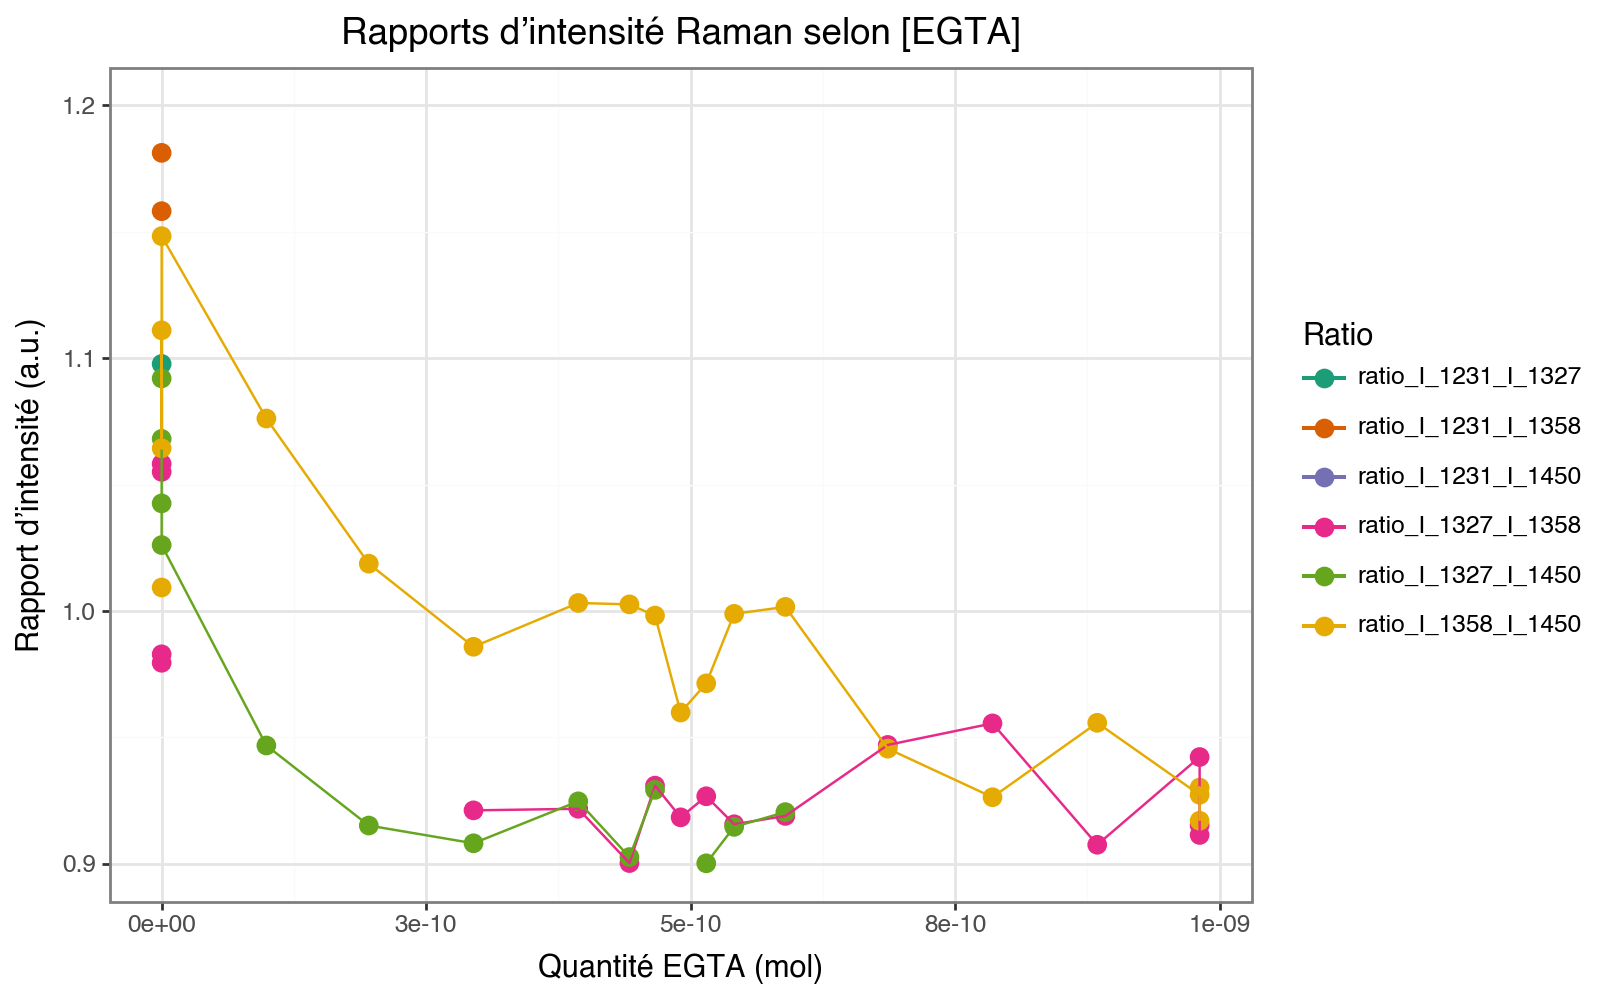

In [158]:
# Tracé
p = (
    ggplot(df_ratios, aes(x="n(EGTA) (mol)", y="Value", color="Ratio"))
    + geom_point(size=3)
    + geom_line(aes(group="Ratio"))
    + theme_bw()
    + labs(
        title="Rapports d’intensité Raman selon [EGTA]",
        x="Quantité EGTA (mol)",
        y="Rapport d’intensité (a.u.)"
    )
    + scale_color_brewer(type='qual', palette='Dark2')
    + scale_x_continuous(labels=lambda l: [f"{x:.0e}" for x in l])
    + theme(figure_size=(8, 5))
    + ylim(0.9, 1.2)
)

p